# Parsing Realtime Metrics
Author: John Vivian

Metrics from Toil runs are dumped to a file and must be processed into sparse dataframes before they can be plotted or analyzed.  Metrics analyzed are generated from [this automation pipeline script](https://github.com/jvivian/one_off_scripts/blob/master/automated_scaling_tests.py).  This automation pipeline spins up a cluster

Plots are generated by taking the mean and standard deviation of the timestamp columns.

Cost is estimated by obtaining the start/stop time for each instance, scraping the spot price history for that time period, and calculating the total cost for that individual instance.

In [397]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import numpy as np
from datetime import datetime
from tqdm import tqdm
import logging
import time
import boto.ec2
logging.basicConfig(level=logging.INFO)

In [398]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Preprocessing
First locate the files we want to analyze.

In [412]:
runs = []
for root, dirs, files in os.walk('.'):
    runs.extend(dirs)
runs = [x for x in runs if 'scaling' in x]

In [408]:
metrics = {}
for r in runs:
    metrics[r.split('_')[-1]] = [os.path.join(r, x) for x in os.listdir(r) if '.csv' in x]

For all of these metrics, which consist of lines that contain the **instance ID**, **value**, and **timestamp**, we must create a sparse matrix for each metric, where each row belongs to an instance and the columns are timestamps. 

In [515]:
def create_sparse_matrix(df):
    frames = []
    # Make the dataframe searchable by instance ID
    df.sort(columns=['id'], inplace=True)
    df.set_index(keys=['id'], drop=False, inplace=True)
    names=df['id'].unique().tolist()
    # For each instance id, construct a 1D vector of values
    for instance_id in tqdm(names):
        instance_df = df.loc[df['id'] == instance_id]
        instance_df.sort('timestamp', inplace=True)
        instance_df = instance_df.transpose()
        instance_df.columns = instance_df.iloc[2]
        instance_df.drop(['timestamp', 'id'], inplace=True)
        instance_df.index = [instance_id]
        # This line removes duplicate timestamp intervals
        frames.append(instance_df.T.groupby(level=0).first().T)
    return pd.concat(frames) 

Create a spare matrix for every metric and store in a dictionary.

In [516]:
matrices = {}
for metric in metrics['scaling-gtex-400']:
    df = pd.read_csv( metric, sep='\t', names=['id', 'value', 'timestamp'] )
    matrices[os.path.basename(metric).split('.')[0]] = create_sparse_matrix(df)

## Plotting
We'll now iterate through this dictionary and produce a subplot for each metric. Lastly, we'll compute the number of active nodes at each given time point, translate that into number of cores, and plot it. 

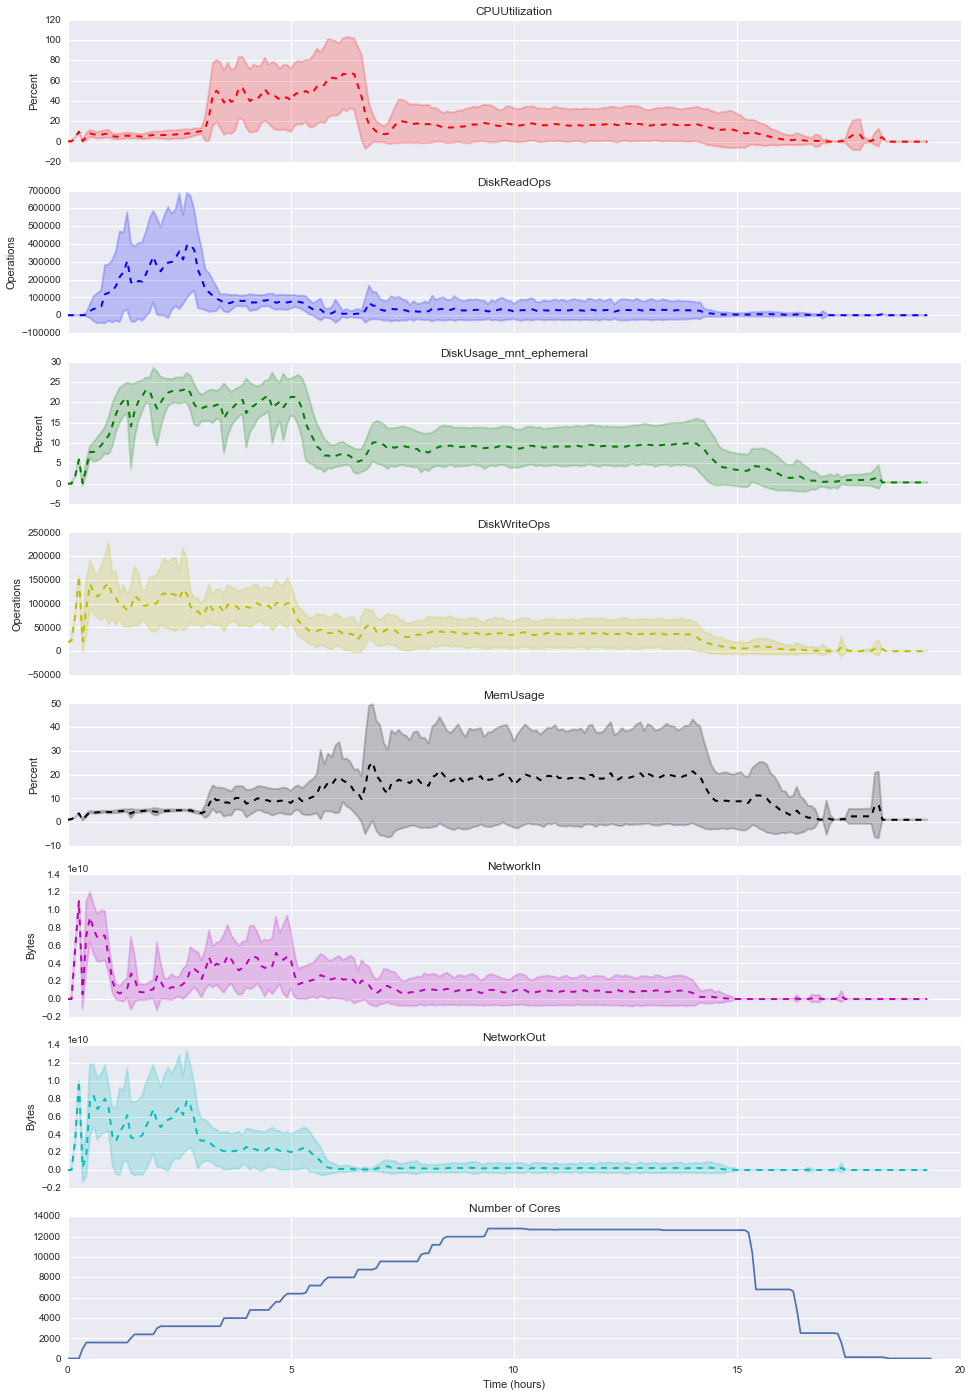

In [526]:
colors = itertools.cycle(["r", "b", "g", 'y', 'k', 'm', 'c'])
ylabels = ['Percent', 'Operations', 'Percent', 'Operations', 'Percent', 'Bytes', 'Bytes']
num_workers = [] 

# Dynamically generate subplots for DRYness and flexibility
metric_info = zip(sorted(matrices.keys()), ylabels)
f, axes = plt.subplots(len(metric_info)+1, sharex=True, figsize=(16, 24))
for i, mi in enumerate(metric_info):
    c = next(colors)
    metric, ylabel = mi
    matrix = matrices[metric]
    mean = matrix.mean()
    std = matrix.std().fillna(0)
    x = [t*5.0/60 for t in xrange(len(mean))]
    axes[i].plot(x, mean, linewidth=2, linestyle='dashed', color=c)
    axes[i].fill_between(x, mean-std, mean+std, alpha=0.2, linewidth=2, color=c);
    axes[i].set_title(metric)
    axes[i].set_ylabel(ylabel)
    num_workers.append(matrix.count())
# We'll calculate the number of workers by taking the max "count" of each metric's timestamp
num_workers = pd.DataFrame(num_workers)
num_instances = num_workers.max()*32
x = [t*5.0/60 for t in xrange(len(num_instances))]
axes[-1].plot(x, num_instances)
axes[-1].set_title("Number of Cores")
axes[-1].set_xlabel('Time (hours)')
plt.show();

## Calculate Costs
We would also like to compute the costs for a given run. This can be done accurately by looking at each instance id's start/stop time, querying amazon's spot market prices for that time frame, and computing a total cost.

In [533]:
def calculate_cost(conn, instance_type='c3.8xlarge', avail_zone='us-west-2a', instance_id=None, 
                   start_time=None, end_time=None, region='us-west-2'):
    if start_time is None or end_time is None:
        assert instance_id, 'If start_time or end_time not supplied, an instance_id must be supplied'
        start_time, end_time = get_start_and_stop(instance_id)
    # Some values
    logging.info('Calculating costs...')
    total, n = 0.0, 0
    min_time = float("inf")
    # Connect to EC2 -- requires ~/.boto
    # Get prices for instance, AZ and time range
    prices = conn.get_spot_price_history(instance_type=instance_type, start_time=start_time,
                                         end_time=end_time, availability_zone=avail_zone)
    # Output the prices
    for price in prices:
        total += price.price
        n += 1
    # Difference b/w first and last returned times
    stop = time.mktime(datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S").timetuple())
    start = time.mktime(datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S").timetuple())
    time_diff = (stop - start) / 3600
    return str(time_diff * (total/n)), str(total / n)

def convert_str_to_datetime(str_time):
    str_time = str_time.replace('-', '').replace(':', '').replace(' ', '')
    str_time = datetime.strptime( str_time, '%Y%m%d%H%M%S')
    return str_time.isoformat()

In [534]:
costs = []
conn = boto.ec2.connect_to_region('us-west-2')
for metric in matrices:
    cost = 0
    matrix = matrices[metric]
    for row in tqdm(matrix.iterrows()):
        row = row[1].dropna()
        start = convert_str_to_datetime(min(row.index))
        end = convert_str_to_datetime(max(row.index))
        total, avg = calculate_cost(conn, start_time=start, end_time=end)
        cost += float(total)
    costs.append(cost)
print 'Run cost ~${}'.format(round(np.median(costs), 2))

Run cost ~$2588.27


Since this run was 2,546 samples, our cost per sample was: **$1.02**, a massive improvement over previously used RNA-seq pipelines. 

`¯\_(ツ)_/¯`